<a href="https://colab.research.google.com/github/nahbos/AUT-Language-Understanding/blob/main/Ex01/G2P_Encoder_Decoder_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 37.2 MB/s 
     |████████████████████████████████| 2.2 MB 54.1 MB/s 


In [2]:
!pip install torchtext==0.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.8 MB/s 
     |████████████████████████████████| 1.3 MB 54.0 MB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.1
    Uninstalling torchtext-0.13.1:
      Successfully uninstalled torchtext-0.13.1


In [3]:
!wget -nc https://raw.githubusercontent.com/nahbos/AUT-Language-Understanding/main/Ex01/HW01/data/train_data.txt
!wget -nc https://raw.githubusercontent.com/nahbos/AUT-Language-Understanding/main/Ex01/HW01/data/test_data.txt

--2022-11-03 15:13:07--  https://raw.githubusercontent.com/nahbos/AUT-Language-Understanding/main/Ex01/HW01/data/train_data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1505929 (1.4M) [text/plain]
Saving to: ‘train_data.txt’

train_data.txt      100%[===================>]   1.44M  --.-KB/s    in 0.008s  

2022-11-03 15:13:07 (189 MB/s) - ‘train_data.txt’ saved [1505929/1505929]

--2022-11-03 15:13:07--  https://raw.githubusercontent.com/nahbos/AUT-Language-Understanding/main/Ex01/HW01/data/test_data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting

In [59]:
# Copyright @fehiepsi: available at [https://fehiepsi.github.io/blog/grapheme-to-phoneme/]
# Replicated by @SobhanMoradianDaghigh on 10-27-2022


# Import Libraries -------------------------
import os
import time
import argparse
import random

import Levenshtein  # for PER I prefer to use Levenshtein rather to jiwer: https://github.com/ztane/python-Levenshtein/


# Torch libs
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.nn.utils import clip_grad_norm
import torchtext.data as data


# Checking if the CUDA is available on the Local system: Sobhans' GTX1050 > returned True
# print(torch.cuda.is_available())


# Setting the args
parser = {
    'data_path': './', #TODO: input()

    'epochs': 7,
    'batch_size': 64,

    'max_len': 40,  # max length of grapheme/phoneme sequences
    'beam_size': 3,  # size of beam for beam-search
    'd_embed': 500,  # embedding dimension
    'd_hidden': 500,  # hidden dimension

    'attention': True,  # use attention or not

    'log_every': 200,  # number of iterations to log and validate training

    'lr': 0.008,  # initial learning rate
    'lr_decay': 0.5,  # decay lr when not observing improvement in val_loss
    'lr_min': 1e-5,  # stop when lr is too low
    'n_bad_loss': 3,  # number of bad val_loss before decaying
    'clip': 2.3,  # clip gradient, to avoid exploding gradient

    'cuda': True,  # using gpu or not
    'seed': 5,  # initial seed
    'intermediate_path': './',  # path to save models
}
args = argparse.Namespace(**parser)


args.cuda = args.cuda and torch.cuda.is_available()
if not os.path.isdir(args.intermediate_path):
    os.makedirs(args.intermediate_path)

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)


class Encoder(nn.Module):

    def __init__(self, vocab_size, d_embed, d_hidden):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_embed)
        self.lstm = nn.LSTMCell(d_embed, d_hidden)
        self.d_hidden = d_hidden

    def forward(self, x_seq, cuda=False):
        o = []
        e_seq = self.embedding(x_seq)  # seq x batch x dim
        tt = torch.cuda if cuda else torch  # use cuda tensor or not
        # create initial hidden state and initial cell state
        h = Variable(tt.FloatTensor(e_seq.size(1), self.d_hidden).zero_())
        c = Variable(tt.FloatTensor(e_seq.size(1), self.d_hidden).zero_())

        for e in e_seq.chunk(e_seq.size(0), 0):
            e = e.squeeze(0)
            h, c = self.lstm(e, (h, c))
            o.append(h)
        return torch.stack(o, 0), h, c


class Attention(nn.Module):

    def __init__(self, dim):
        super(Attention, self).__init__()
        self.linear = nn.Linear(dim * 2, dim, bias=False)

    def forward(self, x, context=None):
        if context is None:
            return x
        assert x.size(0) == context.size(0)  # x: batch x dim
        assert x.size(1) == context.size(2)  # context: batch x seq x dim
        attn = F.softmax(context.bmm(x.unsqueeze(2)).squeeze(2), dim=1)
        weighted_context = attn.unsqueeze(1).bmm(context).squeeze(1)
        o = self.linear(torch.cat((x, weighted_context), 1))
        return torch.tanh(o)


class Decoder(nn.Module):

    def __init__(self, vocab_size, d_embed, d_hidden):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_embed)
        self.lstm = nn.LSTMCell(d_embed, d_hidden)
        self.attn = Attention(d_hidden)
        self.linear = nn.Linear(d_hidden, vocab_size)

    def forward(self, x_seq, h, c, context=None):
        o = []
        e_seq = self.embedding(x_seq)
        for e in e_seq.chunk(e_seq.size(0), 0):
            e = e.squeeze(0)
            h, c = self.lstm(e, (h, c))
            o.append(self.attn(h, context))
        o = torch.stack(o, 0)
        o = self.linear(o.view(-1, h.size(1)))
        return F.log_softmax(o, dim=1).view(x_seq.size(0), -1, o.size(1)), h, c


class Beam(object):
    def __init__(self, size, pad=1, bos=2, eos=3, cuda=False):
        """Initialize params."""
        self.size = size
        self.done = False
        self.pad = pad
        self.bos = bos
        self.eos = eos
        self.tt = torch.cuda if cuda else torch

        # The score for each translation on the beam.
        self.scores = self.tt.FloatTensor(size).zero_()

        # The backPointers at each time-step.
        self.prevKs = []

        # The outputs at each time-step.
        self.nextYs = [self.tt.LongTensor(size).fill_(self.pad)]
        self.nextYs[0][0] = self.bos

    # Get the outputs for the current timestep.
    def get_current_state(self):
        """Get state of beam."""
        return self.nextYs[-1]

    # Get the backPointers for the current timestep.
    def get_current_origin(self):
        """Get the backpointer to the beam at this step."""
        return self.prevKs[-1]

    def advance(self, workd_lk):
        """Advance the beam."""
        num_words = workd_lk.size(1)

        # Sum the previous scores.
        if len(self.prevKs) > 0:
            beam_lk = workd_lk + self.scores.unsqueeze(1).expand_as(workd_lk)
        else:
            beam_lk = workd_lk[0]

        flat_beam_lk = beam_lk.view(-1)

        bestScores, bestScoresId = flat_beam_lk.topk(self.size, 0, True, True)
        self.scores = bestScores

        # bestScoresId is flattened beam x word array, so calculate which
        # word and beam each score came from
        prev_k = torch.div(bestScoresId, num_words, rounding_mode='floor')
        self.prevKs.append(prev_k)
        self.nextYs.append(bestScoresId - prev_k * num_words)
        # End condition is when top-of-beam is EOS.
        if self.nextYs[-1][0] == self.eos:
            self.done = True
        return self.done

    def get_hyp(self, k):
        """Get hypotheses."""
        hyp = []
        # print(len(self.prevKs), len(self.nextYs), len(self.attn))
        for j in range(len(self.prevKs) - 1, -1, -1):
            hyp.append(self.nextYs[j + 1][k])
            k = self.prevKs[j][k]
        return hyp[::-1]


class G2P(nn.Module):

    def __init__(self, config):
        super(G2P, self).__init__()
        self.encoder = Encoder(config.g_size, config.d_embed, config.d_hidden)
        self.decoder = Decoder(config.p_size, config.d_embed, config.d_hidden)
        self.config = config

    def forward(self, g_seq, p_seq=None):
        o, h, c = self.encoder(g_seq, self.config.cuda)
        context = o.transpose(0, 1) if self.config.attention else None
        if p_seq is not None:  # not generate
            return self.decoder(p_seq, h, c, context)
        else:
            assert g_seq.size(1) == 1  # make sure batch_size = 1
            return self._generate(h, c, context)

    def _generate(self, h, c, context):
        beam = Beam(self.config.beam_size, cuda=self.config.cuda)
        # Make a beam_size batch.
        h = h.expand(beam.size, h.size(1))
        c = c.expand(beam.size, c.size(1))
        context = context.expand(beam.size, context.size(1), context.size(2))

        for i in range(self.config.max_len):  # max_len = 40
            x = beam.get_current_state()
            o, h, c = self.decoder(Variable(x.unsqueeze(0)), h, c, context)
            if beam.advance(o.data.squeeze(0)):
                break
            h.data.copy_(h.data.index_select(0, beam.get_current_origin()))
            c.data.copy_(c.data.index_select(0, beam.get_current_origin()))
        tt = torch.cuda if self.config.cuda else torch
        return Variable(tt.LongTensor(beam.get_hyp(0)))


def phoneme_error_rate(p_seq1, p_seq2):
    p_vocab = set(p_seq1 + p_seq2)
    p2c = dict(zip(p_vocab, range(len(p_vocab))))
    c_seq1 = [chr(p2c[p]) for p in p_seq1]
    c_seq2 = [chr(p2c[p]) for p in p_seq2]
    return Levenshtein.distance(''.join(c_seq1), ''.join(c_seq2)) / len(c_seq2)


def adjust_learning_rate(optimizer, lr_decay):
    for param_group in optimizer.param_groups:
        param_group['lr'] *= lr_decay


train_loss_history, val_loss_history = [], []

def train(config, train_iter, model, criterion, optimizer, epoch):
    global iteration, n_total, train_loss, n_bad_loss
    global init, best_val_loss, stop, train_loss_history, val_loss_history

    print("=> EPOCH {}".format(epoch))
    train_iter.init_epoch()

    for batch in train_iter:
        model.train()

        output, _, __ = model(batch.grapheme, batch.phoneme[:-1].detach())
        target = batch.phoneme[1:]
        loss = criterion(output.view(output.size(0) * output.size(1), -1), target.view(target.size(0) * target.size(1)))

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.clip, 'inf')
        optimizer.step()

        train_loss += loss.data.item()

        train_loss_history.append(train_loss)

        if iteration % config.log_every == 0:

            val_loss = validate(val_iter, model, criterion)
            val_loss_history.append(val_loss)

            print("   % Time: {:5.0f} | Iteration: {:5} | Batch: {:4}/{}"
                  " | Train loss: {:.4f} | Val loss: {:.4f}"
                  .format(time.time() - init, iteration, train_iter.iterations,
                          len(train_iter), train_loss, val_loss))

            # test for val_loss improvement
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                n_bad_loss = 0
                torch.save(model.state_dict(), config.best_model)
            else:
                n_bad_loss += 1
            if n_bad_loss == config.n_bad_loss:
                best_val_loss = val_loss
                n_bad_loss = 0
                adjust_learning_rate(optimizer, config.lr_decay)
                new_lr = optimizer.param_groups[0]['lr']
                print("=> Adjust learning rate to: {}".format(new_lr))
                if new_lr < config.lr_min:
                    stop = True
                    break
                    
        train_loss = 0
        iteration += 1


def validate(val_iter, model, criterion):
    model.eval()
    val_loss = 0
    val_iter.init_epoch()
    for batch in val_iter:
        output, _, __ = model(batch.grapheme, batch.phoneme[:-1])
        target = batch.phoneme[1:]
        loss = criterion(output.squeeze(1), target.squeeze(1))
        val_loss += loss.data.item() * batch.batch_size
    return val_loss / len(val_iter.dataset)


def test(test_iter, model, criterion):
    model.eval()
    test_iter.init_epoch()
    test_per = test_wer = 0
    for batch in test_iter:
        output = model(batch.grapheme).data.tolist()
        target = batch.phoneme[1:].squeeze(1).data.tolist()
        # calculate per, wer here
        per = phoneme_error_rate(output, target)
        wer = int(output != target)
        test_per += per  # batch_size = 1
        test_wer += wer

    test_per = test_per / len(test_iter.dataset) * 100
    test_wer = test_wer / len(test_iter.dataset) * 100
    print("Phoneme error rate (PER): {:.2f}\nWord error rate (WER): {:.2f}"
          .format(test_per, test_wer))


def show(batch, model):
    assert batch.batch_size == 1
    g_field = batch.dataset.fields['grapheme']
    p_field = batch.dataset.fields['phoneme']
    prediction = model(batch.grapheme).data.tolist()[:-1]
    grapheme = batch.grapheme.squeeze(1).data.tolist()[1:][::-1]
    phoneme = batch.phoneme.squeeze(1).data.tolist()[1:-1]
    print("> {}\n= {}\n< {}\n".format(
        ''.join([g_field.vocab.itos[g] for g in grapheme][::-1]),
        ''.join([p_field.vocab.itos[p] for p in phoneme][::-1]),
        ''.join([p_field.vocab.itos[p] for p in prediction][::-1])))


g_field = data.Field(init_token='<s>', tokenize=(lambda x: list(x)))
p_field = data.Field(init_token='<os>', eos_token='</os>', tokenize=(lambda x: list(x)[::-1]))

class G2PPersianDataset(data.Dataset):

    def __init__(self, data_lines, g_field, p_field):
        fields = [('grapheme', g_field), ('phoneme', p_field)]
        examples = []
        for line in data_lines:
            grapheme, phoneme = line.split(maxsplit=1)
            examples.append(data.Example.fromlist([grapheme, phoneme], fields))
        self.sort_key = lambda x: len(x.grapheme)
        super(G2PPersianDataset, self).__init__(examples, fields)

    @classmethod
    def splits(cls, train_path, test_path, g_field, p_field, seed=None):
        import random

        if seed is not None:
            random.seed(seed)

        with open(train_path) as f1:
            tr_lines = f1.readlines()

        with open(test_path) as f2:
            ts_lines = f2.readlines()

        random.shuffle(tr_lines)

        train_lines, val_lines, test_lines = [], [], []

        for i, line in enumerate(tr_lines):
            if i % 60 < 1:  # Try to separate about 5% val from 65000
                val_lines.append(line)
            else:
                train_lines.append(line)

        for i, line in enumerate(ts_lines):
            test_lines.append(line)

        print((len(train_lines), len(val_lines), len(test_lines)))
        # Returned: (61750, 3250, 10164)

        train_data = cls(train_lines, g_field, p_field)
        val_data = cls(val_lines, g_field, p_field)
        test_data = cls(test_lines, g_field, p_field)

        return train_data, val_data, test_data


tr_filepath = os.path.join(args.data_path, 'train_data.txt')
ts_filepath = os.path.join(args.data_path, 'test_data.txt')

train_data, val_data, test_data = G2PPersianDataset.splits(tr_filepath, ts_filepath, g_field, p_field, args.seed)

g_field.build_vocab(train_data, val_data, test_data)
p_field.build_vocab(train_data, val_data, test_data)

device = torch.device('cuda') if args.cuda else torch.device('cpu')
train_iter = data.BucketIterator(train_data, batch_size=args.batch_size, repeat=False, device=device)
val_iter = data.Iterator(val_data, batch_size=1, train=False, sort=False, device=device)
test_iter = data.Iterator(test_data, batch_size=1, train=False, shuffle=True, device=device)

config = args
config.g_size = len(g_field.vocab)
config.p_size = len(p_field.vocab)
config.best_model = os.path.join(config.intermediate_path, "best_model_adagrad_attn.pth")

model = G2P(config)
criterion = nn.NLLLoss()
if config.cuda:
    model.cuda()
    criterion.cuda()
optimizer = optim.Adagrad(model.parameters(), lr=config.lr)  # use Adagrad

if 1 == 1:  # change to True to train
    iteration = n_total = train_loss = n_bad_loss = 0
    stop = False
    best_val_loss = 10
    init = time.time()
    for epoch in range(1, config.epochs + 1):
        train(config, train_iter, model, criterion, optimizer, epoch)
        if stop:
            break


(63916, 1084, 10164)
=> EPOCH 1
   % Time:     4 | Iteration:     0 | Batch:    1/999 | Train loss: 3.4676 | Val loss: 4.8688
   % Time:    12 | Iteration:   200 | Batch:  201/999 | Train loss: 0.2161 | Val loss: 0.4443
   % Time:    19 | Iteration:   400 | Batch:  401/999 | Train loss: 0.1895 | Val loss: 0.3924
   % Time:    27 | Iteration:   600 | Batch:  601/999 | Train loss: 0.1116 | Val loss: 0.3085
   % Time:    34 | Iteration:   800 | Batch:  801/999 | Train loss: 0.1353 | Val loss: 0.2795
=> EPOCH 2
   % Time:    42 | Iteration:  1000 | Batch:    2/999 | Train loss: 0.1460 | Val loss: 0.2644
   % Time:    49 | Iteration:  1200 | Batch:  202/999 | Train loss: 0.1063 | Val loss: 0.2657
   % Time:    56 | Iteration:  1400 | Batch:  402/999 | Train loss: 0.1235 | Val loss: 0.2542
   % Time:    64 | Iteration:  1600 | Batch:  602/999 | Train loss: 0.1457 | Val loss: 0.2442
   % Time:    71 | Iteration:  1800 | Batch:  802/999 | Train loss: 0.0964 | Val loss: 0.2332
=> EPOCH 3
   % T

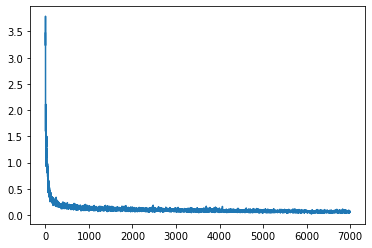

In [60]:
import matplotlib.pyplot as plt
plt.plot(train_loss_history)

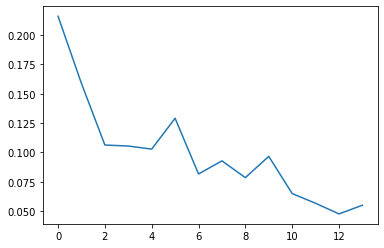

In [61]:
plt.plot(train_loss_history[200::500])

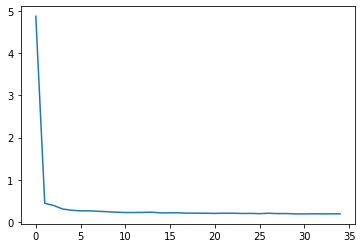

In [62]:
plt.plot(val_loss_history)

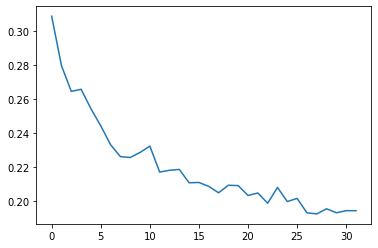

In [66]:
plt.plot(val_loss_history[3:])

In [65]:
model.load_state_dict(torch.load(config.best_model))
test(test_iter, model, criterion)

Phoneme error rate (PER): 7.23
Word error rate (WER): 37.52


In [64]:
test_iter.init_epoch()
random_tests = random.sample(range(0, len(test_iter)), 50)
for i, batch in enumerate(test_iter):
    if i in random_tests:
        show(batch, model)

> ازت
= 'azot
< 'azet

> بطم
= botm
< botm

> خرز
= xarz
< xarz

> سرو
= serv
< sarv

> سورن
= suran
< suren

> فرجه
= forje
< farje

> قاری
= qAri
< qAri

> مسجد
= masjed
< masjed

> مضیع
= mozayye'
< mazi'

> وهله
= vahle
< vahle

> بی‌خس
= bixas
< bixos

> تفریع
= tafri'
< tafri'

> تقارن
= taqAron
< taqAron

> ره‌گو
= rahgu
< rahgu

> شارشک
= SAraSk
< SArSek

> متعبد
= mota'abbed
< mote'abbed

> مکثار
= meksAr
< moksAr

> پوشپر
= puSpar
< puSpar

> یک‌دم
= yekdam
< yekdam

> درباره
= darbAre
< darbAre

> رهابنه
= rahAbene
< rahAbene

> سردوشی
= sarduSi
< sarduSi

> شیرونه
= Sirune
< Sirune

> برومندی
= borumandi
< borumandi

> تفصیلاً
= tafsilan
< tafsilan

> دراننده
= darAnande
< darAnande

> سلحشوری
= salahSuri
< solhSuri

> شبکه‌ای
= Sabake'i
< Sabke'i

> فوت‌شده
= fotSode
< futSode

> ناشتائی
= nAStA'i
< nAStA'i

> هلفدانی
= holofdAni
< halafdAni

> پراگندن
= parAgandan
< parAgandan

> پریکارد
= perikArd
< perikArd

> اسپکولوم
= 'espekulom
< 'espekolom

> به‌گزارش
= begozAreSe


Finito))